___
___
# **Proyecto Final Data Science**
## **Modelo de asociación**

Equipo: 2 - Quantum Insights
Integrantes:
- Felipe Varela - Product Owner
- Freddy Yaquive - Data Scientist
- Ivan Martinez - Data Scientist
- Sebastian Moya - Data Scientist
- Nicolás Lazarte - Scrum Master

Cohorte: DSFT01
___
___

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

df_order_items = pd.read_csv("order_items.csv")
df_orders = pd.read_csv("orders.csv")
df_products = pd.read_csv("products.csv")

In [46]:
# Se junta las tablas orders y order_items, para su entrenamiento de asociacion 
df_orders_final = df_orders.merge(df_order_items, how="left")

### Transformacion de tablas para 0 y 1, filas = usuarios, columnas = productos

In [47]:
df_ratings = df_orders_final.groupby(['user_id', 'product_id']).size().reset_index(name='purchase_count')
matriz_utilidad = df_ratings.pivot(index='user_id', columns='product_id', values='purchase_count')
matriz_utilidad = matriz_utilidad.fillna(0)

print("Matriz creada\n")
print("-"*40)
print(matriz_utilidad.iloc[:3,:3])

Matriz creada

----------------------------------------
product_id  P000001  P000002  P000003
user_id                              
U000001         0.0      0.0      0.0
U000002         0.0      0.0      0.0
U000003         0.0      0.0      0.0


In [48]:
# Reduce la matriz de 2000 a 20, significa que en general agrupa a los patrones mas relevantes y crea 20 "grupos"
svd = TruncatedSVD(n_components=20, random_state=42)
matriz_comprimida = svd.fit_transform(matriz_utilidad)
porectanje_var = svd.explained_variance_ratio_.sum() * 100
print(f"\nCon 20 componentes explicamos el {porectanje_var:.2f}% de la varianza original.")


Con 20 componentes explicamos el 2.38% de la varianza original.


In [49]:
import numpy as np

# 1. Reconstruir la matriz (Descomprimir)
# Esto genera una matriz densa donde YA NO HAY CEROS.
# Los valores ahora son "Scores de Probabilidad de Compra".
matriz_predicha = svd.inverse_transform(matriz_comprimida)

# Lo convertimos a DataFrame para que sea fácil de leer (manteniendo los nombres de columnas e índices)
df_predicciones = pd.DataFrame(
    matriz_predicha,
    index=matriz_utilidad.index,
    columns=matriz_utilidad.columns
)

print("Matriz de Predicciones generada exitosamente.")
print(df_predicciones.iloc[:5, :5])

Matriz de Predicciones generada exitosamente.
product_id   P000001   P000002   P000003   P000004   P000005
user_id                                                     
U000001     0.002214  0.000822  0.006253  0.000851 -0.008178
U000002     0.001174  0.002718 -0.004480  0.011177  0.014650
U000003     0.003087  0.004503  0.000517  0.003954 -0.003969
U000004     0.000240 -0.004209 -0.006116  0.003539  0.009288
U000005    -0.001199  0.001191 -0.000492  0.000800  0.003947


In [50]:
# def obtener_recomendaciones_svd(user_id, df_preds, matriz_real, df_nombres_productos, top_n=5):
#     """
#     Genera recomendaciones de descubrimiento para un usuario específico.
#     Filtra los productos que el usuario YA compró anteriormente.
#     """
#     # 1. Verificar si el usuario existe
#     if user_id not in df_preds.index:
#         return f"El usuario {user_id} no tiene historial. Usar Modelo A (Populares)."

#     # 2. Obtener las predicciones del usuario ordenadas de mayor a menor
#     # (Aquí están TODOS los productos, incluso los que ya compró)
#     predicciones_usuario = df_preds.loc[user_id].sort_values(ascending=False)

#     # 3. Obtener lo que el usuario REALMENTE ya compró (Historial)
#     historial_usuario = matriz_real.loc[user_id]
#     productos_comprados = historial_usuario[historial_usuario > 0].index

#     # 4. FILTRO DE DESCUBRIMIENTO:
#     # Quitamos de la lista lo que ya compró, para recomendarle SOLO cosas nuevas.
#     recomendaciones_nuevas = predicciones_usuario.drop(productos_comprados)

#     # 5. Tomamos los Top N
#     top_recos = recomendaciones_nuevas.head(top_n)

#     # 6. Formatear bonito con Nombres de Productos
#     # Asumo que df_products tiene 'product_id' y 'ProductName'
#     resultado = []
#     print(f"--- Recomendaciones para {user_id} ---")
#     for prod_id, score in top_recos.items():
#         # Buscamos el nombre
#         nombre = df_nombres_productos.loc[df_nombres_productos['product_id'] == prod_id, 'ProductName'].values
#         nombre_limpio = nombre[0] if len(nombre) > 0 else "Producto Desconocido"
        
#         print(f"⭐ {nombre_limpio} (Score: {score:.4f})")
#         resultado.append([prod_id, nombre_limpio, score])
        
#     return resultado

# # --- ZONA DE PRUEBAS ---
# # Escoge un ID de usuario que sepas que existe en tu matriz
# # (Puedes ver los índices con matriz_utilidad.index)
# usuario_prueba = matriz_utilidad.index[0] 

# # Ejecutamos la función
# # Asegúrate de pasar tu df_products original para que busque los nombres
# recs = obtener_recomendaciones_svd("U000025", df_predicciones, matriz_utilidad, df_products)

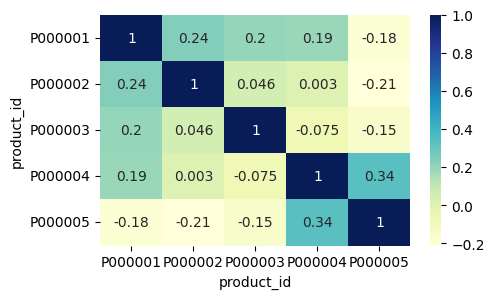

In [59]:
matriz_productos_latente = svd.components_.T
similitud_productos = cosine_similarity(matriz_productos_latente)
df_similitud = pd.DataFrame(
    similitud_productos,
    index=matriz_utilidad.columns,
    columns=matriz_utilidad.columns
)
plt.figure(figsize=(5,3))
sns.heatmap(df_similitud.iloc[:5,:5], annot=True,cmap="YlGnBu")
plt.show()

In [60]:
def recomendar_similares_garantizado(product_id, df_sim, df_info_productos, top_n=3):
    # 1. Validaciones
    if product_id not in df_sim.index:
        return [] # Retorna lista vacía si es producto nuevo
    # Obtener info del producto actual
    try:
        info_actual = df_info_productos[df_info_productos['product_id'] == product_id].iloc[0]
        categoria_actual = info_actual['Category']
    except IndexError:
        return [] # Error si el ID no está en el maestro de productos

    # 2. Buscar candidatos (Aumentamos a 100 para saltar los "pescados")
    candidatos = df_sim[product_id].drop(product_id).sort_values(ascending=False).head(100)
    
    recomendaciones_fimes = [] # Aquí guardamos los de la MISMA categoría
    recomendaciones_extra = [] # Aquí guardamos los de OTRAS categorías (por si acaso)

    for pid, score in candidatos.items():
        # Info del candidato
        info_cand = df_info_productos[df_info_productos['product_id'] == pid]
        if info_cand.empty: continue
        
        cat_cand = info_cand.iloc[0]['Category']
        nom_cand = info_cand.iloc[0]['ProductName']
        subcta_cand = info_cand.iloc[0]['SubCategory']

        item = [pid, nom_cand,cat_cand,subcta_cand, score] # Formato para la lista

        # Clasificamos
        if cat_cand == categoria_actual:
            if len(recomendaciones_fimes) < top_n:
                recomendaciones_fimes.append(item)
        else:
            # Guardamos los "intrusos" fuertes solo como reserva
            if len(recomendaciones_extra) < top_n:
                recomendaciones_extra.append(item)
        
        # Si ya tenemos 3 firmes, terminamos temprano
        if len(recomendaciones_fimes) >= top_n:
            break
    
    # 3. Lógica de Relleno (Si no llegamos a 3)
    resultado_final = recomendaciones_fimes
    
    if len(resultado_final) < top_n:
        faltantes = top_n - len(resultado_final)
        # Rellenamos con los mejores "extra" que encontramos
        resultado_final.extend(recomendaciones_extra[:faltantes])
        print(f"⚠️ Aviso: Se completaron {faltantes} espacios con productos de otras categorías.")

    # Mostrar en consola para verificar
    print(f"--- Recomendaciones para {product_id} ({categoria_actual}) ---")
    # print(resultado_final[0])
    for item in resultado_final:
        print(f"⭐ {item[1]},\nCategoria: {item[2]},\nSubcategoria: {item[3]}\nScore: {item[4]:.2f}")

    return 

# --- PRUEBA ---
# Usa uno de los IDs que te daba problemas antes
id_problematico = "P000046" # O usa matriz_utilidad.columns[50]
recomendar_similares_garantizado(id_problematico, df_similitud, df_products,3)

--- Recomendaciones para P000046 (Kitchen, Garden & Pets) ---
⭐ Stainless Steel Idly Cooker - 4 Plates, 16 Idly, Sturdy, Long Lasting,
Categoria: Kitchen, Garden & Pets,
Subcategoria: Cookware Sets
Score: 0.57
⭐ Non-Stick Cookware Gift Set - Blue, Flat Tawa 26 cm + Kadai with SS Lid 22.5 cm, 2.8 mm,
Categoria: Kitchen, Garden & Pets,
Subcategoria: Cookware Sets
Score: 0.51
⭐ Ceramic Dining Bowl/Katori - Floral Design, Hand Painted, Ancient Royal Blue,
Categoria: Kitchen, Garden & Pets,
Subcategoria: Plates & Bowls
Score: 0.46
